# Setup libraries and import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as LGBMRegressor

In [2]:
df = pd.read_csv('assets/data_asset/sample_asset_care.csv')
df['date_converted'] =  pd.to_datetime(df['datetime'])
df.head(5)

/tmp/1000670000/ipykernel_876/3626354677.py:2: UserWarning: Parsing '13/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date_converted'] =  pd.to_datetime(df['datetime'])
/tmp/1000670000/ipykernel_876/3626354677.py:2: UserWarning: Parsing '14/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date_converted'] =  pd.to_datetime(df['datetime'])
/tmp/1000670000/ipykernel_876/3626354677.py:2: UserWarning: Parsing '15/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date_converted'] =  pd.to_datetime(df['datetime'])
/tmp/1000670000/ipykernel_876/3626354677.py:2: UserWarning: Parsing '16/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date_converted'] =  pd.to_datetime(df['datetime'])
/tmp/1000670000/ipykernel_876/3626354677.py:2: UserW

,datetime,Incidents,holiday,onsitesupport,facilityupgrade,reporting,date_converted
0,1/1/2016,112,0,1,0,0,2016-01-01
1,2/1/2016,148,0,1,0,0,2016-02-01
2,3/1/2016,158,0,1,0,0,2016-03-01
3,4/1/2016,199,0,1,0,0,2016-04-01
4,5/1/2016,183,0,1,0,0,2016-05-01


# Feature Engineering

In [3]:
# List of feature engineering
df['year'] = pd.DatetimeIndex(df['date_converted']).year
df['month'] = pd.DatetimeIndex(df['date_converted']).month 
df['week'] = df['date_converted'].dt.week
df['dayofweek'] = df['date_converted'].dt.dayofweek  
df['dayofyear'] = df['date_converted'].dt.dayofyear

df['lag_1'] = df['Incidents'].shift(1)
df['lag_2'] = df['Incidents'].shift(2)
df['lag_3'] = df['Incidents'].shift(3) 

df['lag_365'] = df['Incidents'].shift(365) 

df['rolling_mean'] = df['Incidents'].rolling(window=7).mean()

df = df.replace(np.nan, 0)

df.head(10)

/tmp/1000670000/ipykernel_876/3345480022.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date_converted'].dt.week


,datetime,Incidents,holiday,onsitesupport,facilityupgrade,reporting,date_converted,year,month,week,dayofweek,dayofyear,lag_1,lag_2,lag_3,lag_365,rolling_mean
0,1/1/2016,112,0,1,0,0,2016-01-01,2016,1,53,4,1,0.0,0.0,0.0,0.0,0.000000
1,2/1/2016,148,0,1,0,0,2016-02-01,2016,2,5,0,32,112.0,0.0,0.0,0.0,0.000000
2,3/1/2016,158,0,1,0,0,2016-03-01,2016,3,9,1,61,148.0,112.0,0.0,0.0,0.000000
3,4/1/2016,199,0,1,0,0,2016-04-01,2016,4,13,4,92,158.0,148.0,112.0,0.0,0.000000
4,5/1/2016,183,0,1,0,0,2016-05-01,2016,5,17,6,122,199.0,158.0,148.0,0.0,0.000000
5,6/1/2016,249,0,0,0,0,2016-06-01,2016,6,22,2,153,183.0,199.0,158.0,0.0,0.000000
6,7/1/2016,282,0,0,0,0,2016-07-01,2016,7,26,4,183,249.0,183.0,199.0,0.0,190.142857
7,8/1/2016,291,0,0,0,0,2016-08-01,2016,8,31,0,214,282.0,249.0,183.0,0.0,215.714286
8,9/1/2016,211,0,0,0,0,2016-09-01,2016,9,35,3,245,291.0,282.0,249.0,0.0,224.714286
9,10/1/2016,145,0,0,0,0,2016-10-01,2016,10,39,5,275,211.0,291.0,282.0,0.0,222.857143


# Data Visualisation

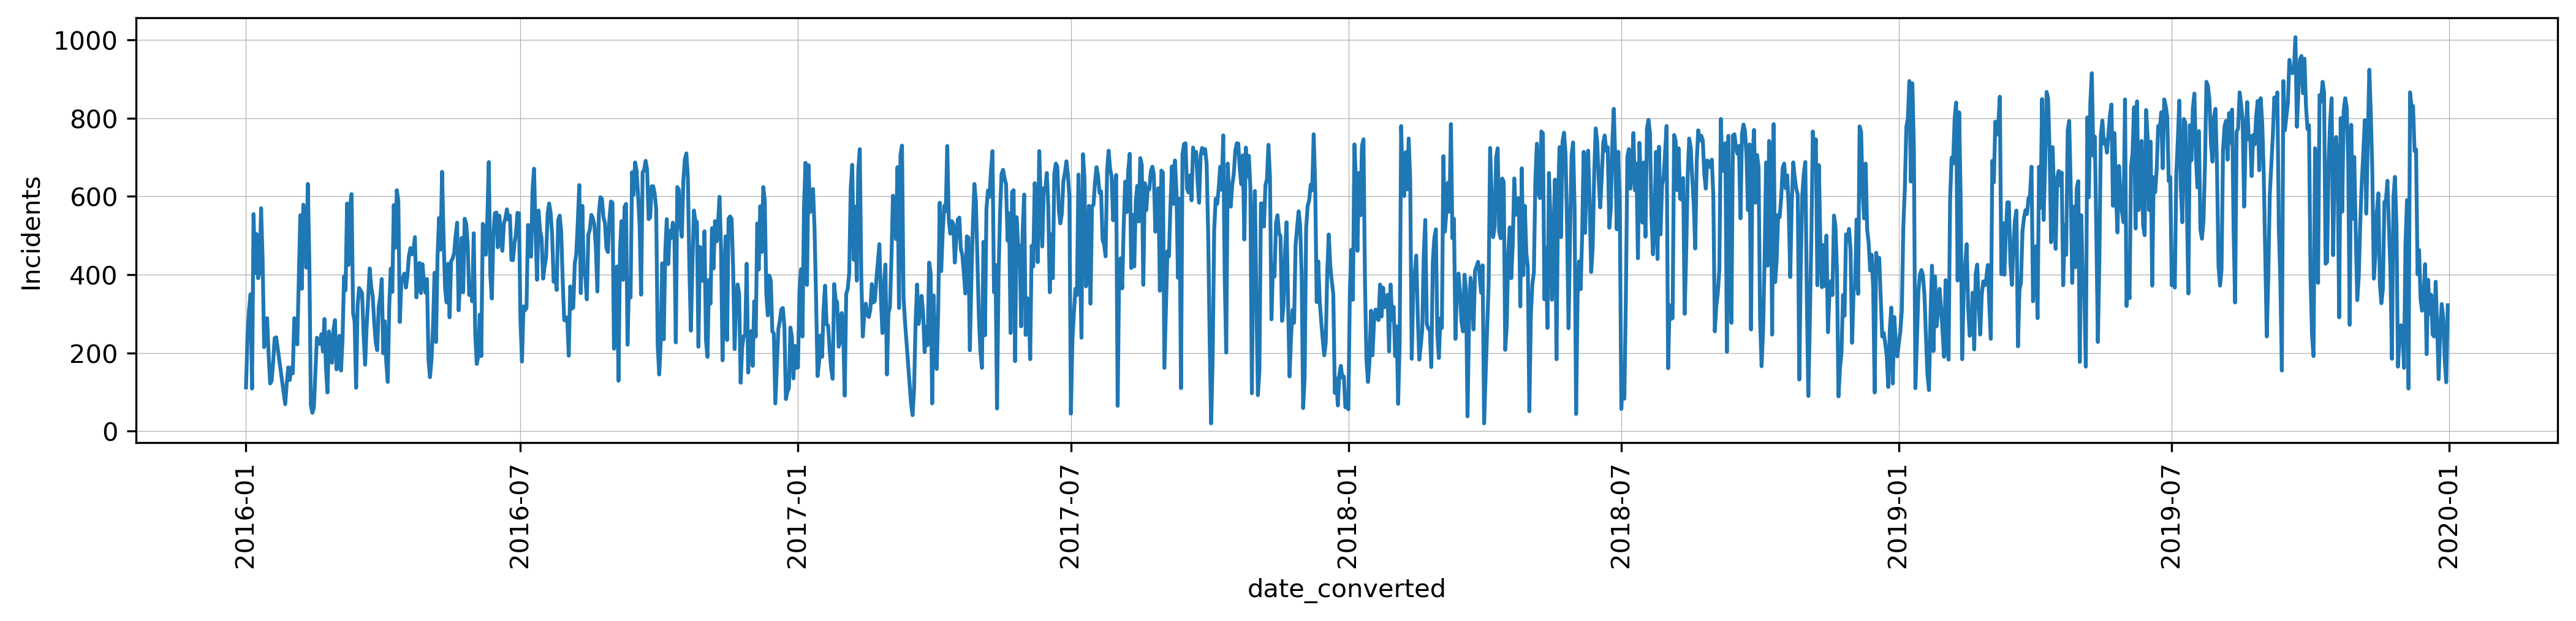

In [4]:
# plot the trend graph
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df, x='date_converted', y='Incidents')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# Modelling 

In [6]:
features = ['month', 'week', 'dayofweek', 'dayofyear', 'lag_1', 'lag_2', 'lag_3', 'lag_365', 'rolling_mean', 'holiday', 'onsitesupport', 'facilityupgrade', 'reporting']
label = 'Incidents'
train_df = df[df['year'] >= 2017]
train_df = train_df[train_df['year'] < 2019]
test_df = df[df['year'] >= 2019]
test_df = test_df[test_df['year'] < 2020]
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

### Train an XGBoost model

In [7]:
reg = XGBRegressor(n_estimators=100, learning_rate=0.1)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:428.62168	validation_1-mae:520.66574
[1]	validation_0-mae:386.47651	validation_1-mae:472.77305
[2]	validation_0-mae:348.59385	validation_1-mae:429.45769
[3]	validation_0-mae:314.66067	validation_1-mae:397.10869
[4]	validation_0-mae:284.19604	validation_1-mae:368.71933
[5]	validation_0-mae:256.97255	validation_1-mae:337.77465
[6]	validation_0-mae:232.74784	validation_1-mae:315.15583
[7]	validation_0-mae:210.95061	validation_1-mae:291.06381
[8]	validation_0-mae:191.36889	validation_1-mae:270.03014
[9]	validation_0-mae:174.04800	validation_1-mae:255.33466
[10]	validation_0-mae:158.48646	validation_1-mae:242.08079
[11]	validation_0-mae:144.75302	validation_1-mae:227.50700
[12]	validation_0-mae:132.59437	validation_1-mae:217.06231
[13]	validation_0-mae:121.88744	validation_1-mae:206.38212
[14]	validation_0-mae:112.44309	validation_1-mae:197.02003
[15]	validation_0-mae:103.99516	validation_1-mae:189.86761
[16]	validation_0-mae:96.45969	validation_1-mae:182.85863
[17]	val

/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-mae:24.93108	validation_1-mae:123.87446
[79]	validation_0-mae:24.70524	validation_1-mae:123.82252
[80]	validation_0-mae:24.26997	validation_1-mae:123.78829
[81]	validation_0-mae:23.94710	validation_1-mae:123.51507
[82]	validation_0-mae:23.78455	validation_1-mae:123.48622
[83]	validation_0-mae:23.21507	validation_1-mae:123.54811
[84]	validation_0-mae:22.91613	validation_1-mae:123.47228
[85]	validation_0-mae:22.64990	validation_1-mae:123.59138
[86]	validation_0-mae:22.45104	validation_1-mae:123.64720
[87]	validation_0-mae:22.29185	validation_1-mae:123.55391
[88]	validation_0-mae:22.11792	validation_1-mae:123.62729
[89]	validation_0-mae:21.77226	validation_1-mae:123.70798
[90]	validation_0-mae:21.44728	validation_1-mae:123.71842
[91]	validation_0-mae:21.26391	validation_1-mae:123.75478
[92]	validation_0-mae:21.09122	validation_1-mae:123.75438
[93]	validation_0-mae:20.95801	validation_1-mae:123.85443
[94]	validation_0-mae:20.57804	validation_1-mae:123.83588
[95]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### Predict on the trained model on test data

In [8]:
predictions = reg.predict(X_test)

### Visualise the predictions

In [9]:
frames = [test_df, train_df]
df_all = pd.concat(frames)

test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

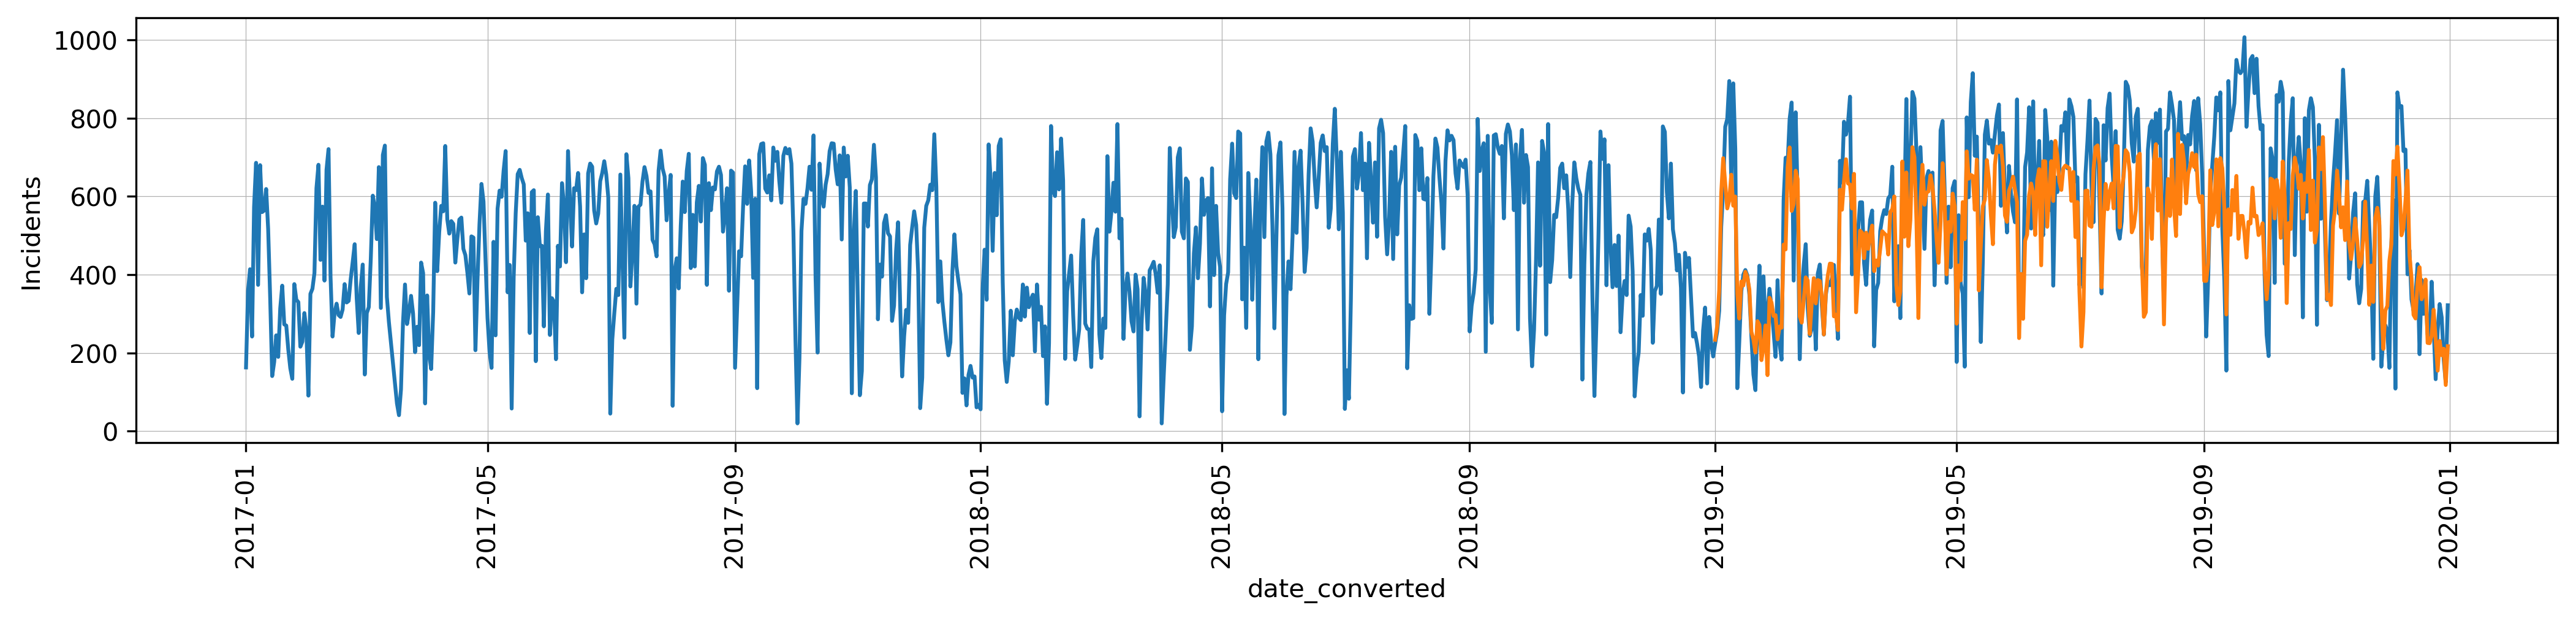

In [10]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df_all, x='date_converted', y='Incidents')
sns.lineplot(data=test_df, x='date_converted', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

### Identify and evaluate key drivers

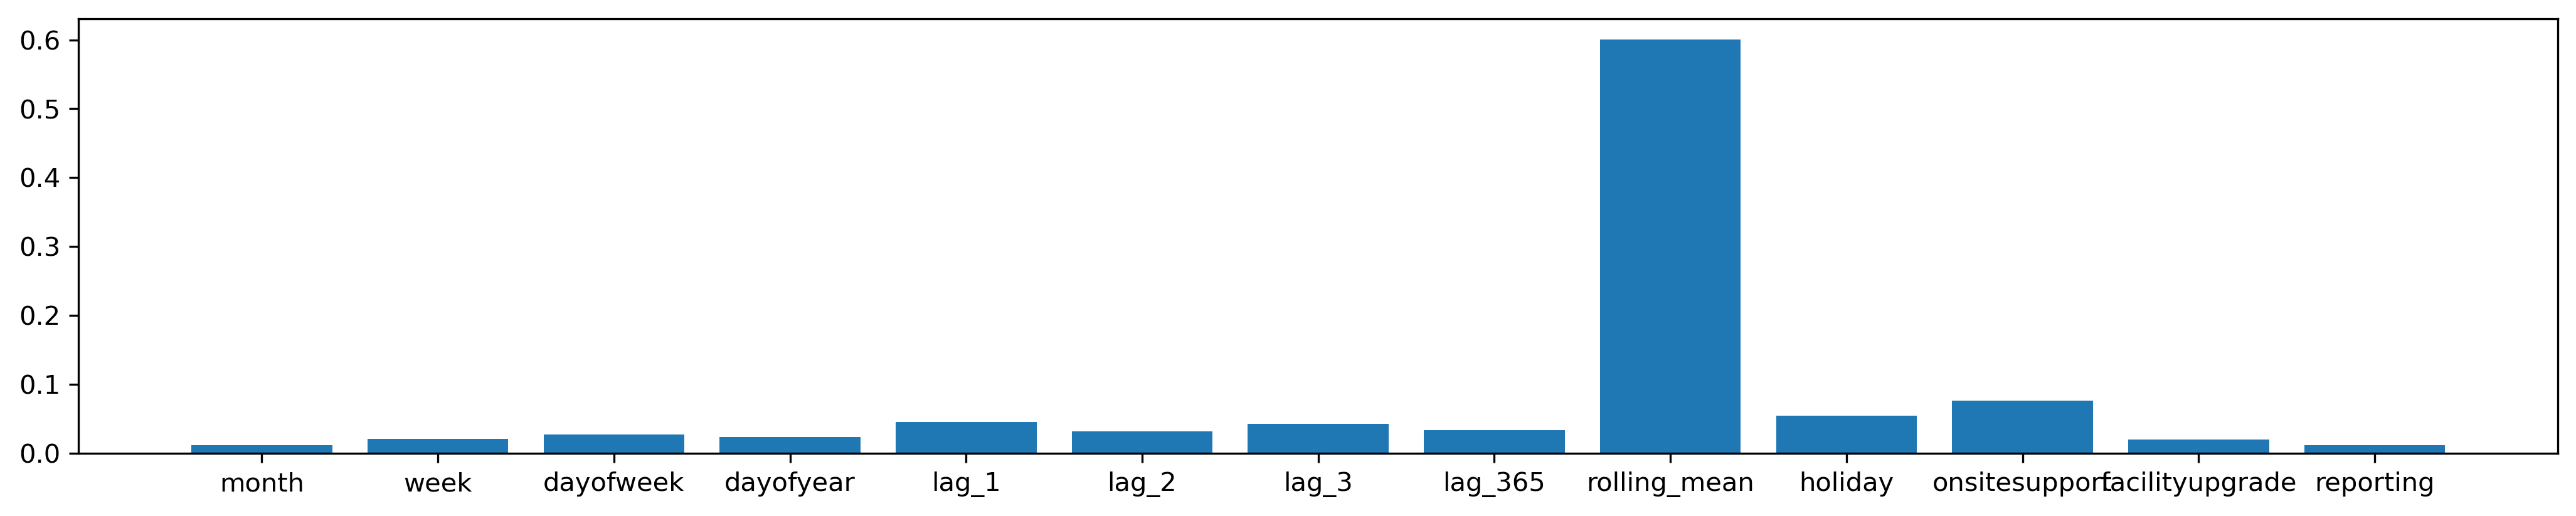

In [11]:
# plot
plt.bar(features, reg.feature_importances_)
plt.show()

# Compare Different Models

In [12]:
# Import dependencies
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [13]:
pipelines = {
    'rf':make_pipeline(RandomForestRegressor(random_state=1234)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=1234)),
    'ridge':make_pipeline(Ridge(random_state=1234)),
    'lasso':make_pipeline(Lasso(random_state=1234)),
    'enet':make_pipeline(ElasticNet(random_state=1234)),
}

In [14]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [15]:
hypergrid = {
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [17]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for ridge.
ridge has been successfully fit.
Starting training for lasso.


/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+04, tolerance: 2.254e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+06, tolerance: 2.531e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

lasso has been successfully fit.
Starting training for enet.


/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e+04, tolerance: 2.254e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e+06, tolerance: 2.531e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

enet has been successfully fit.


#### Model Evaluation

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

In [19]:
for algo,model in fit_models.items():
    yhat = model.predict(X_test)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)))

rf scores - R2:0.6534793402481387 MAE:103.91162497312429
gb scores - R2:0.5935327445461865 MAE:111.52776403550432
ridge scores - R2:0.738840480439082 MAE:86.34373175866546
lasso scores - R2:0.7389089295462503 MAE:85.87654568948614
enet scores - R2:0.7380850186870995 MAE:85.89251822004121


In [20]:
best_model = fit_models['lasso']

In [21]:
best_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('lasso', Lasso(random_state=1234))]),
             n_jobs=1,
             param_grid={'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                          0.99]})

# Model Deployment 

### Import and install dependencies

In [ ]:
#!pip install -U ibm-watson-machine-learning
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

### Authenticate and Set Space

In [ ]:
wml_credentials = {
    "apikey":"morZwa0PdZgBEjSgzxsplnN3fYbxqpi56MirKJ74priZ",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [ ]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

In [ ]:
SPACE_ID="5a5e95fd-aafe-40b6-b261-b5f7eb4108b7"
wml_client.set.default_space(SPACE_ID)

### Save the model

In [ ]:
MODEL_NAME = 'SampleE2E'
DEPLOYMENT_NAME = 'SampleE2E_Deployment'
BEST_MODEL = best_model

In [ ]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.10')

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}
 
#Save model
model_details = wml_client.repository.store_model(
    model=BEST_MODEL, 
    meta_props=model_props, 
    training_data=X_train,
    training_target=y_train
) 

model_details

In [ ]:
model_uid = wml_client.repository.get_model_id(model_details); 

### Deploy the model

In [ ]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_uid, 
    meta_props=deployment_props 
)

# Output result
deployment

# Score Against Deployed Model

In [ ]:
deployment_uid = wml_client.deployments.get_uid(deployment)
payload = {"input_data":
           [
               {"fields":X_test.columns.to_numpy().tolist(), "values":X_test.to_numpy().tolist()}
           ]
          }
result = wml_client.deployments.score(deployment_uid, payload); result

In [ ]:
payload

### Export the results

In [ ]:
pred_values = np.squeeze(result['predictions'][0]['values']); pred_values
preddf = X_test.join(y_test)
preddf['Scores'] = pred_values
preddf.head()

In [ ]:
preddf.to_csv('SampleE2E_Results.csv')